In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from utils import db_utils
from utils import iefp_data_utils
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Connect to database
conn = db_utils.connect_to_db()

In [3]:
#Read movements data from database as a dataframe
movements = db_utils.read_table(conn,'cascais_v2','movement')

In [4]:
#Read Application Data
applications = db_utils.read_table(conn,'cascais_v2','application')

In [5]:
clean_apps = iefp_data_utils.clean_applications(applications,'1980-01-01','2016-04-30')

In [6]:
clean_movs = iefp_data_utils.clean_movements(movements,'1980-01-01','2017-04-30')

In [7]:
clean_movs.head()

,ute_id,movement_event_date,application_id,movement_type,movement_subtype,movement_result,movement_index
5,710,2016-12-06,120687,application,DESEMPREGADO-NOVO EMPREGO,,120687
6,710,2016-12-06,120687,intervention,ENTREVISTA COLOCAÃÃO,CONCLUIU,434113
7,710,2017-01-10,120687,convocation,INTERVENÃÃO TÃCNICA,COMPARECEU,257387
8,710,2017-01-16,120687,intervention,ENTREVISTA ORIENTAÃÃO,CONCLUIU,439065
9,710,2017-02-03,120687,convocation,OFERTA,ANULADA,258569


In [8]:
clean_data = pd.merge(clean_movs,clean_apps,how='inner', left_on = ['ute_id','application_id'], right_on=['ute_id','table_index'])

In [9]:
clean_data.shape

(1028041, 68)

In [10]:
clean_data.head()

,ute_id,movement_event_date,application_id,movement_type,movement_subtype,movement_result,movement_index,anomes,ctipo_movimento,dtipo_movimento,...,conjuge_categoria,conjuge_estado,conjuge_motivo_indisponibilidade,candidatura_categoria_anterior,candidatura_estado_anterior,ute_nr_pessoas_cargo,ute_nr_descendentes_cargo,candidatura_data_ppe,table_index,app_start_date
0,818,2013-02-18,70870,application,DESEMPREGADO-NOVO EMPREGO,,70870,201302,11,PEDIDOS DE EMPREGO AO LONGO DO MÃS,...,None,None,None,None,None,2,2,None,70870,2013-02-18
1,818,2013-02-18,70870,intervention,INICIO PPE,INICIADO,228179,201302,11,PEDIDOS DE EMPREGO AO LONGO DO MÃS,...,None,None,None,None,None,2,2,None,70870,2013-02-18
2,818,2013-02-18,70870,intervention,ENTREVISTA COLOCAÃÃO,CONCLUIU,228180,201302,11,PEDIDOS DE EMPREGO AO LONGO DO MÃS,...,None,None,None,None,None,2,2,None,70870,2013-02-18
3,818,2013-04-04,70870,convocation,OFERTA,APRESENTADO,124146,201302,11,PEDIDOS DE EMPREGO AO LONGO DO MÃS,...,None,None,None,None,None,2,2,None,70870,2013-02-18
4,818,2013-04-08,70870,interview,588061835,RECUSA DA ENTIDADE EMPREGADORA - NÃO MARCAÃÃ...,104497,201302,11,PEDIDOS DE EMPREGO AO LONGO DO MÃS,...,None,None,None,None,None,2,2,None,70870,2013-02-18


In [11]:
def get_apps_cancellations(x):
    return x[x['movement_type'].isin(['cancellation'])].groupby(['application_id']).first().reset_index()[['application_id','movement_event_date']].rename(columns={'movement_event_date': 'cancellation_date'})

def get_apps_placements(x):
    return x[x['movement_result'].isin(['ADMITIDO / COLOCADO'])].groupby(['application_id']).first().reset_index()[['application_id','movement_event_date']].rename(columns={'movement_event_date': 'placement_date'})

In [12]:
apps_cancelled = get_apps_cancellations(clean_movs)
apps_placed = get_apps_placements(clean_movs)

In [13]:
apps_cancelled.head()

,application_id,cancellation_date
0,1,2007-02-22
1,3,2007-07-24
2,4,2007-11-16
3,5,2007-04-10
4,6,2007-11-21


In [14]:
apps_placed.head()

,application_id,placement_date
0,2,2007-02-07
1,11,2007-02-27
2,36,2008-04-22
3,65,2007-01-19
4,70,2007-01-08


In [15]:
apps_length = clean_apps.merge(apps_cancelled,how='left', left_on='table_index',right_on='application_id').merge(apps_placed,how='left', left_on='table_index',right_on='application_id')[['table_index','app_start_date','cancellation_date','placement_date']]
apps_length.head()

,table_index,app_start_date,cancellation_date,placement_date
0,70870,2013-02-18,2015-03-26,NaT
1,22642,2009-03-20,2011-11-29,NaT
2,61038,2012-05-17,2013-01-29,NaT
3,1941,2007-03-27,NaT,2007-10-15
4,9206,2007-12-10,2008-02-01,NaT


In [16]:
def get_exit_date(app):
    exit_date = None
    if (pd.notnull(app['cancellation_date'])):
        if (pd.notnull(app['placement_date'])):
            return min(app['cancellation_date'],app['placement_date'])
        else:
            return app['cancellation_date']
    elif (pd.notnull(app['placement_date'])):
        return app['placement_date']
    else:
        return pd.to_datetime(dt.datetime.today().strftime("%m/%d/%Y"))

apps_length['app_exit_date'] = apps_length.apply(get_exit_date,axis=1)

In [17]:
apps_length.head()

,table_index,app_start_date,cancellation_date,placement_date,app_exit_date
0,70870,2013-02-18,2015-03-26,NaT,2015-03-26
1,22642,2009-03-20,2011-11-29,NaT,2011-11-29
2,61038,2012-05-17,2013-01-29,NaT,2013-01-29
3,1941,2007-03-27,NaT,2007-10-15,2007-10-15
4,9206,2007-12-10,2008-02-01,NaT,2008-02-01


In [18]:
def difftime_in_months(timeA,timeB):
    return (timeA-timeB)/np.timedelta64(1, 'M')

apps_length['app_length'] = difftime_in_months(apps_length['app_exit_date'],apps_length['app_start_date'])

In [19]:
apps_length.head()

,table_index,app_start_date,cancellation_date,placement_date,app_exit_date,app_length
0,70870,2013-02-18,2015-03-26,NaT,2015-03-26,25.166841
1,22642,2009-03-20,2011-11-29,NaT,2011-11-29,32.329206
2,61038,2012-05-17,2013-01-29,NaT,2013-01-29,8.443705
3,1941,2007-03-27,NaT,2007-10-15,2007-10-15,6.636687
4,9206,2007-12-10,2008-02-01,NaT,2008-02-01,1.741309


# Overall Analysis

In [20]:
apps_length['app_length'].describe()

count    108801.000000
mean         12.132478
std          15.853318
min          -0.021866
25%           2.759810
50%           5.881024
75%          15.737489
max         203.667426
Name: app_length, dtype: float64

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


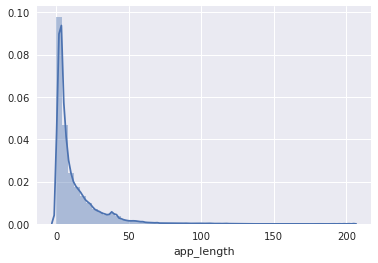

In [21]:
sns.distplot(apps_length['app_length'])

In [34]:
def get_app_length_bucket(apps):
    if (apps['app_length'] <=14):
        return int(apps['app_length'])
    else:
        return 15
    
apps_length['app_length_bucket'] = apps_length.apply(get_app_length_bucket, axis=1)
    

In [35]:
apps_length['app_length_bucket'].describe()

count    108801.000000
mean          7.207903
std           5.685559
min           0.000000
25%           2.000000
50%           5.000000
75%          15.000000
max          15.000000
Name: app_length_bucket, dtype: float64

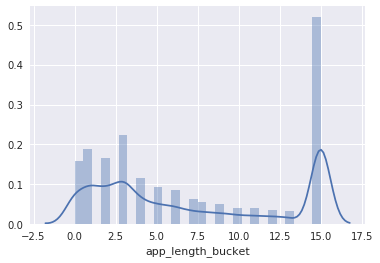

In [36]:
sns.distplot(apps_length['app_length_bucket'])

# Per Year Analysis

In [37]:
apps_length['year'] = apps_length['app_start_date'].dt.year
apps_length.head()

,table_index,app_start_date,cancellation_date,placement_date,app_exit_date,app_length,app_length_bucket,year
0,70870,2013-02-18,2015-03-26,NaT,2015-03-26,25.166841,15,2013
1,22642,2009-03-20,2011-11-29,NaT,2011-11-29,32.329206,15,2009
2,61038,2012-05-17,2013-01-29,NaT,2013-01-29,8.443705,8,2012
3,1941,2007-03-27,NaT,2007-10-15,2007-10-15,6.636687,6,2007
4,9206,2007-12-10,2008-02-01,NaT,2008-02-01,1.741309,1,2007


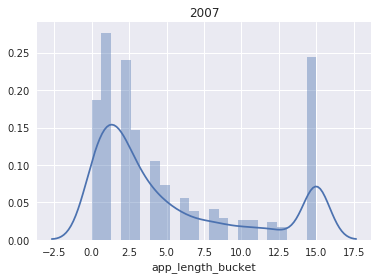

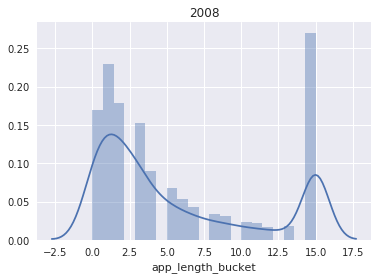

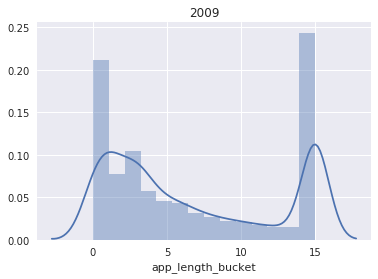

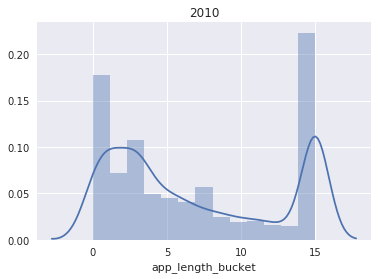

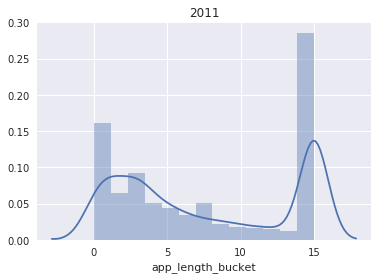

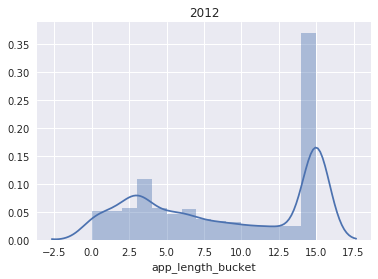

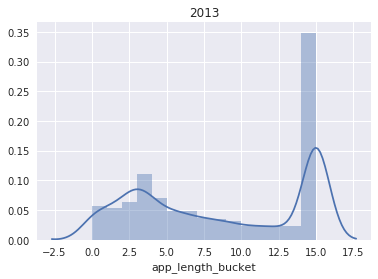

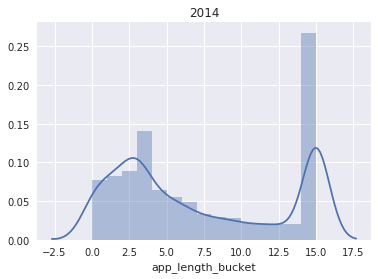

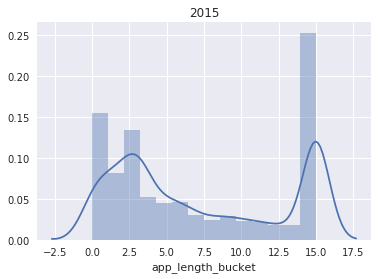

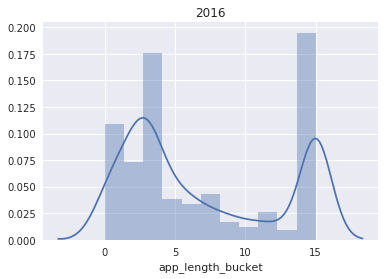

In [38]:
for year in range(2007,2017):
    year_data = apps_length[apps_length['year'] == year]
    ax = plt.axes()
    sns.distplot(year_data['app_length_bucket'], ax=ax)
    ax.set_title(str(year))
    plt.show()